In [22]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
from scipy import ndimage
from scipy.interpolate import griddata
from IPython.display import display, Markdown, Latex

%matplotlib inline

In [23]:
import TileUtility
HT = TileUtility.HalfTiles(TileUtility.FullTiles())

In [24]:
# Takes a 5x5 array of terrains (0,1,2,3,4,5) and crowns (0, 1, 2, 3)
#  and returns score per kingdomino rules
#  size of each contiguous region as defined by orthogonal adjacency
#   times the number of crowns within that region
def scoreDomino(terrain, crowns):
    visited = np.zeros((5,5), 'uint8')
    score = []
    
    for I in range(25):
        i, j = I // 5, I % 5
    
        # If we haven't seen this tile yet and it's an actual tile
        # as opposed to the home tile or the table top
        if visited[i, j] == 0 and terrain[i, j] >= 0 and terrain[i, j] < 6:
            
            # Add to the queue
            queue = [(i, j)]
            T = terrain[i, j]
            C = 0  # Crowns
            N = 0  # Tiles

            # While the queue is not empty,
            #  tally up the crowns and add other adjacent tiles
            #  of the same terrain to the queue.
            current = []
            while len(queue) > 0:
                x, y = queue.pop(0)
                
                # This is needed because the same tile could be added by multiple
                # neighbors.  I can probably get rid of this with a rewrite..
                if visited[x, y] == 1: continue

                C = C + crowns[x, y]
                N = N + 1
                visited[x, y] = 1
                current.append((x,y))

                neighbors = [ (x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1) ]
                for xx, yy in neighbors:
                    # Make the sure the tile is inbounds
                    if (xx < 0 or xx > 4 or yy < 0 or yy > 4): continue
                    # ...and it is the right terrain
                    if terrain[xx, yy] != T: continue
                    # ...and we haven't already visited it once
                    if visited[xx, yy] == 1: continue
                    queue.append((xx, yy))

            score.append({"tiles": current, "terrain": TileUtility.itot(T), "crowns": C, "numtiles": N, "total": C*N})
    return score

def prettyPrintScore(score):   
    row  = "| Region | Tiles | Crowns | Subtotal | Tiles |\n"
    row += "| ---    | ---:   | ---:    | ---: | :---  |\n"
    letters = "ABCDE"
    subtotal = 0
    for i, s in enumerate(score):
        subtotal += s["total"]
        row = row + "| " + s["terrain"] + " | " + str(s["numtiles"]) + " | " + str(s["crowns"])
        row = row + " | " + str(s["total"])  + " | "
        
        temp = ""
        for t in s["tiles"]:
            temp += letters[t[1]] + str(t[0]) + ","
        temp = temp[0:len(temp)-1]
        row = row + temp + " |\n"
    row += "| __Total__  | | | " + str(subtotal) + " | |\n"
    return row

In [ ]:
# Some test data to work out the kinks.

corners = {
    "195508": [ (2568, 2769), (2074, 1984), (2975, 1686), (3750, 2294) ],
    "195451": [ (1521, 672), (605, 1354), (1964, 2064), (2632, 1126)],
    "195443": [ (322, 1373), (1547, 1646), (1956, 673), (931, 522)],
    "193723": [ (958, 1805), (3176, 1730), (2702, 887), (1312, 920) ],
    "193726": [ (102, 2437), (2549, 2204), (2213, 817), (593, 888) ],
    "193728": [ (1671, 1962), (3600, 2242), (3064, 911), (1677, 499) ],
    "193743": [ (2078, 1316), (3255, 1312), (3034, 697), (2099, 703) ],
    "195431": [ (344, 2326), (2719, 1997), (2232, 732), (567, 795) ],
    "195506": [ (491, 1677), (2185, 2115), (2656, 776), (1293, 617) ],    
    "193745": [ (2326, 1232), (4038,1149), (3571, 133), (2242, 194)],
    "193730": [ (685, 2102), (2520, 1714), (2367, 495), (1045, 888)],
    "193734": [ (813, 2594), (2743, 2515), (2548, 830), (937, 859)],
    "193753": [ (1239, 1730), (2255, 2718), (3271, 1693), (2201, 1094)],
    "195436": [ (366, 1898), (1656, 1936), (1777, 852), (662, 850)],
    "193748": [ (1788, 1540), (3120, 1528), (2879, 727), (1821, 722)],
    "193747": [ (1111, 1879), (2928, 1809), (2656, 611), (1255, 627)],
    "195447": [ (1251, 1962), (2540, 1834), (2259, 863), (1123, 875)],
    "193756": [ (2065, 1160), (2846, 1065), (3424, 1677), (2532, 1859)],
    "193759": [ (834, 2689), (3552, 2838), (3296, 545), (1189, 504)],
    "195439": [ (950, 2284), (2693, 2094), (2354, 1024), (1049, 1090)]    
}

tile_res = 128

for file in os.listdir('dev_images/'):
    label = (file.split("_")[1].split("."))[0]
    board = cv2.cvtColor(cv2.imread("dev_images/" + file), cv2.COLOR_BGR2RGB)

    if label not in corners:
        print("No labels for {0}".format(label))
        continue
    
    dst = np.array([[0, 0], [5*tile_res - 1, 0], [5*tile_res - 1, 5*tile_res - 1], [0, 5*tile_res - 1]], dtype="float32")
    src = np.array([[s[0],s[1]] for s in corners[label]], dtype="float32")

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(board, M, (5*tile_res, 5*tile_res))
    
    plt.figure()
    plt.title(label)
    plt.imshow(warped)

    terrain = np.zeros((5,5), 'uint8')
    crowns = np.zeros((5,5), 'uint8')
    tileCandidates = {}
    
    for i in range(5):
        for j in range(5):
            tile = warped[tile_res*i:tile_res*(i+1), tile_res*j:tile_res*(j+1)]
            terrain[i,j] = HT.predictTerrain(tile)
            crowns[i,j] = HT.predictCrowns(tile)
    
    score = scoreDomino(terrain, crowns)
    markdown = prettyPrintScore(score)
    markdown = "# Score for Board " + label + "\n" + markdown
    display(Markdown(markdown))


# Score for Board 193745
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| swamp | 3 | 0 | 0 | A0,B0,C0 |
| mine | 2 | 2 | 4 | D0,E0 |
| desert | 7 | 2 | 14 | A1,B1,C1,D1,D2,E1,E2 |
| grass | 1 | 1 | 1 | A2 |
| ocean | 4 | 0 | 0 | B2,B3,B4,A3 |
| forest | 6 | 2 | 12 | C2,C3,C4,D4,E4,E3 |
| grass | 1 | 1 | 1 | A4 |
| __Total__  | | | 32 | |


No labels for 135938


# Score for Board 193730
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| grass | 1 | 2 | 2 | A0 |
| desert | 4 | 1 | 4 | B0,C0,D0,E0 |
| desert | 5 | 0 | 0 | A1,A2,A3,B2,A4 |
| swamp | 3 | 1 | 3 | B1,C1,D1 |
| ocean | 5 | 3 | 15 | E1,E2,E3,D2,D3 |
| forest | 6 | 1 | 6 | B3,B4,C3,C4,D4,E4 |
| __Total__  | | | 30 | |


# Score for Board 195431
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| ocean | 9 | 3 | 27 | A0,A1,A2,A3,B3,C3,D3,D4,E3 |
| desert | 2 | 0 | 0 | D0,E0 |
| desert | 2 | 0 | 0 | B1,C1 |
| swamp | 1 | 1 | 1 | D1 |
| forest | 4 | 2 | 8 | E1,E2,D2,C2 |
| desert | 2 | 0 | 0 | B4,C4 |
| __Total__  | | | 36 | |


No labels for 134428
No labels for 134434


# Score for Board 193728
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| grass | 1 | 2 | 2 | A0 |
| desert | 4 | 1 | 4 | B0,C0,D0,E0 |
| desert | 5 | 0 | 0 | A1,A2,A3,B2,A4 |
| swamp | 3 | 1 | 3 | B1,C1,D1 |
| ocean | 5 | 3 | 15 | E1,E2,E3,D2,D3 |
| forest | 6 | 1 | 6 | B3,B4,C3,C4,D4,E4 |
| __Total__  | | | 30 | |


No labels for 140316


# Score for Board 193747
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| swamp | 3 | 0 | 0 | A0,B0,C0 |
| mine | 2 | 2 | 4 | D0,E0 |
| desert | 7 | 2 | 14 | A1,B1,C1,D1,D2,E1,E2 |
| grass | 1 | 1 | 1 | A2 |
| ocean | 4 | 0 | 0 | B2,B3,B4,A3 |
| forest | 6 | 2 | 12 | C2,C3,C4,D4,E4,E3 |
| grass | 1 | 1 | 1 | A4 |
| __Total__  | | | 32 | |


No labels for 135929
No labels for 134443
No labels for 134431


# Score for Board 193734
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| grass | 1 | 2 | 2 | A0 |
| desert | 4 | 1 | 4 | B0,C0,D0,E0 |
| desert | 1 | 0 | 0 | A1 |
| swamp | 9 | 1 | 9 | B1,B2,C1,B3,B4,C3,C4,D4,E4 |
| ocean | 1 | 0 | 0 | D2 |
| swamp | 1 | 1 | 1 | E2 |
| grass | 2 | 2 | 4 | D3,E3 |
| desert | 1 | 0 | 0 | A4 |
| __Total__  | | | 20 | |


No labels for 134441


# Score for Board 193743
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| swamp | 3 | 0 | 0 | A0,B0,C0 |
| mine | 2 | 2 | 4 | D0,E0 |
| desert | 7 | 2 | 14 | A1,B1,C1,D1,D2,E1,E2 |
| grass | 1 | 1 | 1 | A2 |
| ocean | 4 | 0 | 0 | B2,B3,B4,A3 |
| forest | 2 | 2 | 4 | C2,C3 |
| forest | 2 | 0 | 0 | E3,E4 |
| grass | 1 | 1 | 1 | A4 |
| swamp | 2 | 0 | 0 | C4,D4 |
| __Total__  | | | 24 | |


In [5]:
terrain

array([[0, 0, 0, 0, 0],
       [3, 3, 3, 3, 3],
       [3, 2, 6, 1, 1],
       [3, 2, 2, 2, 0],
       [3, 4, 4, 5, 5]], dtype=uint8)

In [6]:
crowns

array([[0, 0, 0, 0, 0],
       [0, 2, 0, 0, 1],
       [2, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 2, 3]], dtype=uint8)

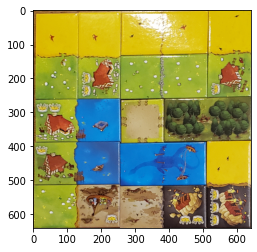

In [7]:
plt.imshow(warped)

In [8]:
i = 0
j = 2
test = warped[128*i:128*(i+1), 128*j:128*(j+1)]
test = cv2.resize(test, (24, 24))
test = np.expand_dims(test, axis = 0)

HT.crowns_model.predict( test )

array([[1., 0., 0., 0.]], dtype=float32)

In [9]:
def tileIntersection(L, R):
    if L is None or R is None: return set([])
    return L.intersection(R)

matches = [ [ (False, set([])) for j in range(5) ] for i in range(5) ]
for i in range(5):
    for j in range(5):        
        T = terrain[i, j]
        C = crowns[i, j]
        
        if (i < 4): down  = HT.tileCandidatesWithPair(T, C, terrain[i + 1, j], crowns[i + 1, j])
        else: down = set([])
            
        if (j < 4): right = HT.tileCandidatesWithPair(T, C, terrain[i, j + 1], crowns[i, j + 1])
        else: right = set([])
            
        for m in down:
            matches[i][j][1].add(m)
            #matches[i + 1][j][1].add(m)
        for m in right:
            matches[i][j][1].add(m)
            #matches[i][j + 1][1].add(m)

        #if (len(matches[i][j][1]) <= 1):           
        #    if len(matches[i][j][1]) == 1:
        #        R = next(iter(matches[i][j][1]))
        #    else:
        #        R = None
        #    matches[i][j] = (True, R)

            #for i in range(5):
#    for j in range(5):
#        matches[i][j] = list(matches[i][j])

def debugMatches(matches):
    row =       "|     | col0   | col1   | col2   | col3   | col4 |\n"
    row = row + "| --- | --- | --- | --- | --- | --- | \n"
    for i in range(5):
        row = row + "| " + "row " + str(i) + " | "
        for j in range(5):
            row = row + str(matches[i][j])

            row = row + " | "
        row = row + "\n"

    display(Markdown(row))

debugMatches(matches)

|     | col0   | col1   | col2   | col3   | col4 |
| --- | --- | --- | --- | --- | --- | 
| row 0 | (False, {('01', False), ('02', True), ('15', False), ('01', True), ('02', False)}) | (False, {('01', False), ('02', True), ('41', False), ('01', True), ('02', False)}) | (False, {('01', False), ('02', True), ('15', False), ('01', True), ('02', False)}) | (False, {('01', False), ('02', True), ('15', False), ('01', True), ('02', False)}) | (False, {('36', False)}) | 
| row 1 | (False, set()) | (False, {('42', True)}) | (False, {('11', False), ('11', True), ('10', False), ('10', True)}) | (False, {('18', True)}) | (False, set()) | 
| row 2 | (False, {('42', True)}) | (False, {('09', True), ('08', True), ('08', False), ('07', True), ('09', False), ('07', False)}) | (False, set()) | (False, {('05', False), ('04', False), ('17', False), ('06', True), ('03', True), ('03', False), ('06', False), ('04', True), ('05', True)}) | (False, {('13', True)}) | 
| row 3 | (False, {('37', True)}) | (False, {('09', True), ('08', True), ('08', False), ('07', True), ('09', False), ('07', False)}) | (False, {('09', True), ('08', True), ('08', False), ('07', True), ('09', False), ('07', False)}) | (False, {('14', True)}) | (False, {('48', False)}) | 
| row 4 | (False, {('39', False)}) | (False, set()) | (False, {('46', False), ('47', False)}) | (False, set()) | (False, set()) | 


In [10]:
import copy

def fixMatch(matches, i, j, tile, iLeft):
    result = copy.deepcopy(matches)
    
    print("i={0}, j={1} tile={2}, iLeft={3}".format(i, j, tile, iLeft))
    assert(result[i[0]][i[1]][0] == False)
    assert(result[j[0]][j[1]][0] == False)
    
    if (iLeft):
        leftTile = tile + "_L"
        rightTile = tile + "_R"
    else:
        leftTile = tile + "_R"
        rightTile = tile + "_L"
    
    for R in range(5):
        for C in range(5):
            if not result[R][C][0]:
                if leftTile in result[R][C][1]: result[R][C][1].remove(leftTile)
                if rightTile in result[R][C][1]: result[R][C][1].remove(rightTile)

    result[i[0]][i[1]] = (True, leftTile)
    result[j[0]][j[1]] = (True, rightTile)
    
    return result

In [11]:
# Try to simplify matches by looking for cells with a single option 
# and then searching neighbors for match.   If there is only a single match
#  that domino must be there.  Place it and remove other options.

def simplifyTiles(matches):
    for i in range(5):
        for j in range(5):
            if not matches[i][j][0] and len(matches[i][j][1]) == 1:
                tile, side = next(iter(matches[i][j][1]))
                if side == 'L': opp = 'R'
                else: opp = 'L'

                otile = (tile, opp)

                #print("Found singleton at {0}, {1}, {2}.  Looking for {3}".format(i, j, (tile, side), otile))

                # Find neighbor tile
                match = 0
                #print(otile)
                if j < 4: print(matches[i][j + 1])
                if i > 0 and not matches[i - 1][j][0] and otile in matches[i - 1][j][1]: match += 8
                if i < 4 and not matches[i + 1][j][0] and otile in matches[i + 1][j][1]: match += 4
                if j > 0 and not matches[i][j - 1][0] and otile in matches[i][j - 1][1]: match += 2
                if j < 4 and not matches[i][j + 1][0] and otile in matches[i][j + 1][1]: match += 1
                #print("Otile {0} found {1}".format(otile, match))

                if match == 1:
                    return True, fixMatch(matches, (i, j), (i, j + 1), tile, side == 'L')
                elif match == 2:
                    return True, fixMatch(matches, (i, j), (i, j - 1), tile, side == 'L')               
                elif match == 4:
                    return True, fixMatch(matches, (i, j), (i + 1, j), tile, side == 'L')
                elif match == 8:
                    return True, fixMatch(matches, (i, j), (i - 1, j), tile, side == 'L')
    return False, matches

In [12]:
nextIter = copy.deepcopy(matches)
while True:
    foundQ, nextIter = simplifyTiles(nextIter)
    if not foundQ: break
        

(False, {('11', False), ('11', True), ('10', False), ('10', True)})
(False, set())
(False, {('09', True), ('08', True), ('08', False), ('07', True), ('09', False), ('07', False)})
(False, {('09', True), ('08', True), ('08', False), ('07', True), ('09', False), ('07', False)})
(False, {('48', False)})
(False, set())


In [13]:
debugMatches(nextIter)

|     | col0   | col1   | col2   | col3   | col4 |
| --- | --- | --- | --- | --- | --- | 
| row 0 | (False, {('01', False), ('02', True), ('15', False), ('01', True), ('02', False)}) | (False, {('01', False), ('02', True), ('41', False), ('01', True), ('02', False)}) | (False, {('01', False), ('02', True), ('15', False), ('01', True), ('02', False)}) | (False, {('01', False), ('02', True), ('15', False), ('01', True), ('02', False)}) | (False, {('36', False)}) | 
| row 1 | (False, set()) | (False, {('42', True)}) | (False, {('11', False), ('11', True), ('10', False), ('10', True)}) | (False, {('18', True)}) | (False, set()) | 
| row 2 | (False, {('42', True)}) | (False, {('09', True), ('08', True), ('08', False), ('07', True), ('09', False), ('07', False)}) | (False, set()) | (False, {('05', False), ('04', False), ('17', False), ('06', True), ('03', True), ('03', False), ('06', False), ('04', True), ('05', True)}) | (False, {('13', True)}) | 
| row 3 | (False, {('37', True)}) | (False, {('09', True), ('08', True), ('08', False), ('07', True), ('09', False), ('07', False)}) | (False, {('09', True), ('08', True), ('08', False), ('07', True), ('09', False), ('07', False)}) | (False, {('14', True)}) | (False, {('48', False)}) | 
| row 4 | (False, {('39', False)}) | (False, set()) | (False, {('46', False), ('47', False)}) | (False, set()) | (False, set()) | 


In [14]:
def oppTile(whichTile):
    tile, side = whichTile
    if side == 'L': opp = 'R'
    else: opp = 'L'
    return tile, opp

def flipTiles(setOfTiles):
    result = set([])
    for s in setOfTiles:
        result.add(oppTile(s))
    return result

def TileClass(setOfTiles):
    if (len(setOfTiles) == 1): return next(iter(setOfTiles))
    else:
        # There are a few tiles that are duplicates but have seperate numbers
        # This collapses them

# Try to simplify matches by looking for cells that
#  only have matches in one direction.
def simplifyTiles2(matches):
    for i in range(5):
        for j in range(5):
            if not matches[i][j][0]:
                
                # Do any of our tiles intersection with N? S? E? W?
                mc = flipTiles(matches[i][j][1])
                adj = [(i - 1, j), (i + 1, j), (i, j - 1), (i, j + 1)]
                
                match = 0
                lastMatchDir = '?'
                for nx, ny in adj:
                    if nx < 0 or nx > 4 or ny < 0 or ny > 4: continue
                    if matches[nx][ny][0]: continue
                    if len(mc.intersection(matches[nx][ny][1])) > 0:
                        match = match + 1
                        lastMatchDir = (nx, ny)
                
                if match == 1:
                    print("Found forced tile @ {0} with tile @ {1}".format((i, j), lastMatchDir))
                    nx, ny = lastMatchDir
                    
                    print("My    tiles {0}.\nOther tiles {1}.\nIntersect'n {2}".format(
                        matches[i][j][1],
                        matches[nx][ny][1],
                        flipTiles(matches[i][j][1]).intersection(matches[nx][ny][1])))
                    
                    T = matches[i][j][1]
                    S = flipTiles(T).intersection(matches[nx][ny][1])
                    matches[i][j] = (True, HT.TileClass(T))
                    matches[nx][ny] = (True, HT.TileClass(S))
               
simplifyTiles2(nextIter)

IndentationError: expected an indented block (<ipython-input-14-4928ef4b5dce>, line 21)

In [ ]:
img = board
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray,25,50)
plt.imshow(edges)

In [ ]:
import cv2
import numpy as np

img = board
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray,100,100,apertureSize = 3)

lines = cv2.HoughLines(edges,1,np.pi/180,5)
for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    print("Found line {0}".format((x1,y1,x2,y2)))

    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

plt.imshow(img)

In [ ]:
?cv2.Canny

In [ ]:
?cv2.HoughLines

In [ ]:
plt.imshow(edges)

In [ ]:
import cv2
import numpy as np

img = board
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)
minLineLength = 500
maxLineGap = 25
lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
print(lines)
for [[x1,y1,x2,y2]] in lines:
    img = cv2.line(img,(x1,y1),(x2,y2),(255,0,0),16)

plt.imshow(img)

In [ ]:
plt.imshow(board)

In [ ]:
?cv2.line

In [ ]:
Zero-parameter, automatic Canny edge detection with Python and OpenCV
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--images", required=True,
	help="path to input dataset of images")
args = vars(ap.parse_args())
# loop over the images
for imagePath in glob.glob(args["images"] + "/*.jpg"):
	# load the image, convert it to grayscale, and blur it slightly
	image = cv2.imread(imagePath)
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	blurred = cv2.GaussianBlur(gray, (3, 3), 0)
	# apply Canny edge detection using a wide threshold, tight
	# threshold, and automatically determined threshold
	wide = cv2.Canny(blurred, 10, 200)
	tight = cv2.Canny(blurred, 225, 250)
	auto = auto_canny(blurred)
	# show the images
	cv2.imshow("Original", image)
	cv2.imshow("Edges", np.hstack([wide, tight, auto]))
	cv2.waitKey(0)

In [ ]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
wide = cv2.Canny(blurred, 10, 200)
tight = cv2.Canny(blurred, 225, 250)
auto = auto_canny(blurred)

plt.figure()
plt.imshow(wide)
plt.figure()
plt.imshow(tight)
plt.figure()
plt.imshow(auto)
